In [2]:
import torch
from abflow.structure import write_to_pdb
from train import setup_model
from utils.load_data import Loader
from utils.utils import load_config

model_name = "codesign_HCDR3_200e"
seed = 42
num_structures = 1
device = torch.device("cuda:0")
batch_size = 10

checkpoint_path = f"/home/jovyan/flow-matching-datavol/model/{model_name}/epoch=199.ckpt"
load_optimizer = False
config_path = f"/home/jovyan/flow-matching-datavol/model/{model_name}/config.yaml"

# load model
config = load_config(config_path)
config["num_workers"] = 1
config["batch_size"] = batch_size
config["devices"] = 1
design_mode = config["design_mode"]
model = setup_model(config, checkpoint_path=checkpoint_path, load_optimizer=load_optimizer)

# redesign complex
ds_loader = Loader(config, dataset_name=config["dataset"])

Number of clusters found: 3145
Number of PDB IDs: 10933
Number of RAbD id: 60
Number of test id (by searching entries of RAbD is): 84
Number of test id (by removing repeats, final): 58
Number of SAbDab IDs (does not need to be unique): 16269
Final number of total SAbDab IDs (different entry id can be associated with same pdb of different chains): 10988
Total number of clusters in training: 3073
Total number of clusters in validation: 10
Total number of clusters in test: 56
Number of structuress in the train split: 10564
Number of structures after final filtering: 6314
Number of clusters found: 3145
Number of PDB IDs: 10933
Number of RAbD id: 60
Number of test id (by searching entries of RAbD is): 84
Number of test id (by removing repeats, final): 58
Number of SAbDab IDs (does not need to be unique): 16269
Final number of total SAbDab IDs (different entry id can be associated with same pdb of different chains): 10988
Total number of clusters in training: 3073
Total number of clusters in

# debug

In [6]:
from abflow.structure import write_to_pdb
import os
import numpy as np
import torch

model.eval()
model.to(device)

data_iter = iter(ds_loader.test_loader)
template_complex = next(data_iter)
redesign_complexes, redesign_trajs = model.generate(template_complex, design_mode=design_mode, seed=seed)

des_dir = f"/home/jovyan/flow-matching-datavol/model/{model_name}/desabs"
if not os.path.exists(des_dir):
    os.makedirs(des_dir)
write_to_pdb(data=template_complex["full_complex"], filepath=f"{des_dir}/full_complex.pdb")
print("true id is", template_complex["full_complex"]["id"])
write_to_pdb(data=template_complex, filepath=f"{des_dir}/WT.pdb")
write_to_pdb(data=redesign_complexes, filepath=f"{des_dir}/DesAb.pdb")
# write traj to pdb - remember plddt per residue is also in redesign_complexes. 
for t, des_t in enumerate(redesign_trajs):
    write_to_pdb(data=des_t, filepath=f"{des_dir}/DesAb_{t}.pdb")

true id is ['4ffv_H_L_A']


# Benchmark

## AbFlow

In [8]:
# get pdb id
test_dataset = ds_loader.test_dataset
test_ids = test_dataset.split_ids

# get the raw data
for test_id in test_ids:
    test_data = test_dataset._get_structure(test_id)
    print(test_data.keys())
    break
# preprocess data as inputs

# for each test complex, generate 100 designs

# get coords, seq, redesign mask

dict_keys(['id', 'heavy', 'heavy_seqmap', 'light', 'light_seqmap', 'antigen', 'antigen_seqmap', 'structure_type', 'light_ctype', 'quality', 'resolution'])


# DiffAb

In [10]:
from abflow.structure import extract_pdb_structure
from abflow.model.metrics import get_rmsd, get_aar, get_bb_clash_violation, get_bb_bond_angle_violation, get_bb_bond_length_violation, get_tm_score
from abflow.data_utils import inv_mask

true_pdb_path = "./benchmarks/diffab/results/codesign_single/7DK2_AB_C.pdb_2024_07_27__13_15_38/reference.pdb"
pred_pdb_path = "./benchmarks/diffab/results/codesign_single/7DK2_AB_C.pdb_2024_07_27__13_15_38/H_CDR3/0012.pdb"
CDR_redesign = "HCDR3"
scheme = "chothia"

true_N_coords, true_CA_coords, true_C_coords, true_CB_coords, true_res_type, true_masks = extract_pdb_structure(true_pdb_path, scheme=scheme)
pred_N_coords, pred_CA_coords, pred_C_coords, pred_CB_coords, pred_res_type, pred_masks = extract_pdb_structure(pred_pdb_path, scheme=scheme)
# redesign_mask = true_cdr_masks[CDR_redesign]
redesign_mask = (true_CA_coords != pred_CA_coords).any(dim=1).to(torch.long)
antibody_mask = true_masks['antibody']
antigen_mask = true_masks['antigen']
print(redesign_mask.shape)
print(antibody_mask.shape)
print(antigen_mask.shape)

true_N_coords = true_N_coords.unsqueeze(0)
true_CA_coords = true_CA_coords.unsqueeze(0)
true_C_coords = true_C_coords.unsqueeze(0)
true_CB_coords = true_CB_coords.unsqueeze(0)
true_res_type = true_res_type.unsqueeze(0)
redesign_mask = redesign_mask.unsqueeze(0)
antibody_mask = antibody_mask.unsqueeze(0)
antigen_mask = antigen_mask.unsqueeze(0)

pred_N_coords = pred_N_coords.unsqueeze(0)
pred_CA_coords = pred_CA_coords.unsqueeze(0)
pred_C_coords = pred_C_coords.unsqueeze(0)
pred_CB_coords = pred_CB_coords.unsqueeze(0)
pred_res_type = pred_res_type.unsqueeze(0)

true_bb_coords = [true_N_coords, true_CA_coords, true_C_coords]
pred_bb_coords = [pred_N_coords, pred_CA_coords, pred_C_coords]


print("----------Fixed Region----------")
print("DiffAb aar: ", get_aar(pred_res_type, true_res_type, masks=[inv_mask(redesign_mask)]))
print("DiffAb ca rmsd: ", get_rmsd([pred_CA_coords], [true_CA_coords], masks=[inv_mask(redesign_mask)]))

print("----------Designed region----------")
print("DiffAb aar: ", get_aar(pred_res_type, true_res_type, masks=[redesign_mask]))
print("DiffAb rmsd: ", get_rmsd([pred_N_coords, pred_CA_coords, pred_C_coords], [true_N_coords, true_CA_coords, true_C_coords], masks=[redesign_mask]))
print("DiffAb ca rmsd: ", get_rmsd([pred_CA_coords], [true_CA_coords], masks=[redesign_mask]))
print("DiffAb backbone clash: ", get_bb_clash_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks_dim_1=[redesign_mask])[1])
print("DiffAb backbone bond angle violation: ", get_bb_bond_angle_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks=[redesign_mask])[1])
print("DiffAb backbone bond length violation: ", get_bb_bond_length_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks=[redesign_mask])[1])
print("DiffAb antibody ca tm score: ", get_tm_score(pred_CA_coords, true_CA_coords, masks=[antibody_mask]))

torch.Size([417])
torch.Size([417])
torch.Size([417])
----------Fixed Region----------
DiffAb aar:  tensor([1.])
DiffAb ca rmsd:  tensor([0.])
----------Designed region----------
DiffAb aar:  tensor([0.0909])
DiffAb rmsd:  tensor([6.3834])
DiffAb ca rmsd:  tensor([6.5075])
DiffAb backbone clash:  tensor([0.0909])
DiffAb backbone bond angle violation:  tensor([0.2727])
DiffAb backbone bond length violation:  tensor([0.6364])
DiffAb antibody ca tm score:  tensor([0.9763])


# MEAN

# Plots

In [3]:
import torch
from abflow.visualization import plot_plddt, plot_aa_distribution, plot_scatter
from abflow.model.metrics import get_batch_lddt, get_rmsd

model.eval()
model.to(device)
test_dataloader = ds_loader.test_loader

with torch.no_grad():
    res_lddt_list = []
    res_plddt_list = []
    batch_lddt_list = []
    batch_ca_rmsd_list = []
    batch_plddt_list = []
    true_seq_list = []
    pred_seq_list = []
    for test_complex in test_dataloader:
        test_complex = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in test_complex.items()}
        redesign_complex, _ = model._generate_complexes(test_complex, design_mode=design_mode, seed=seed)
        true_CA_coords = test_complex['CA_coords']
        redesign_mask = test_complex['redesign_mask']
        pred_CA_coords = redesign_complex['CA_coords']

        res_lddt = redesign_complex['lddt'][redesign_mask.bool()]
        res_plddt = redesign_complex['plddt'][redesign_mask.bool()]
        batch_lddt = get_batch_lddt(redesign_complex['lddt'], [redesign_mask])
        batch_ca_rmsd = get_rmsd([pred_CA_coords], [true_CA_coords], [redesign_mask])
        batch_plddt = get_batch_lddt(redesign_complex['plddt'], [redesign_mask])
        true_seq = test_complex['res_type'][redesign_mask.bool()]
        pred_seq = redesign_complex['res_type'][redesign_mask.bool()]

        res_lddt_list.append(res_lddt)
        res_plddt_list.append(res_plddt)
        batch_lddt_list.append(batch_lddt)
        batch_ca_rmsd_list.append(batch_ca_rmsd)
        batch_plddt_list.append(batch_plddt)
        true_seq_list.append(true_seq)
        pred_seq_list.append(pred_seq)
    
    res_lddt = torch.cat(res_lddt_list, dim=0).cpu()
    res_plddt = torch.cat(res_plddt_list, dim=0).cpu()
    batch_lddt = torch.cat(batch_lddt_list, dim=0).cpu()
    batch_ca_rmsd = torch.cat(batch_ca_rmsd_list, dim=0).cpu()
    batch_plddt = torch.cat(batch_plddt_list, dim=0).cpu()
    true_seq = torch.cat(true_seq_list, dim=0).cpu()
    pred_seq = torch.cat(pred_seq_list, dim=0).cpu()

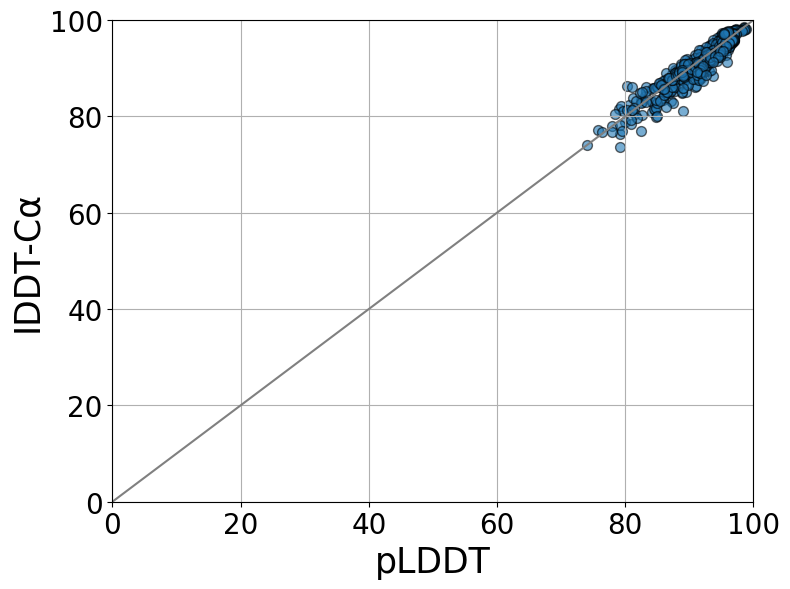

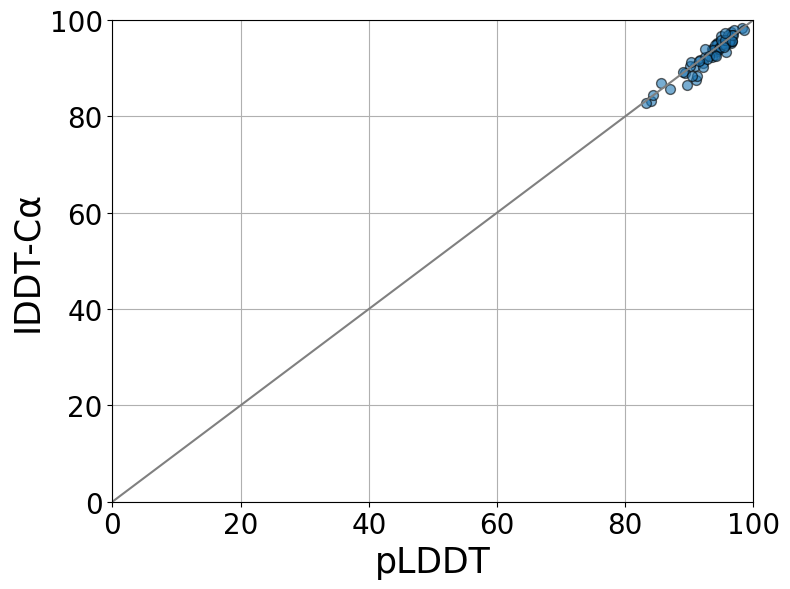

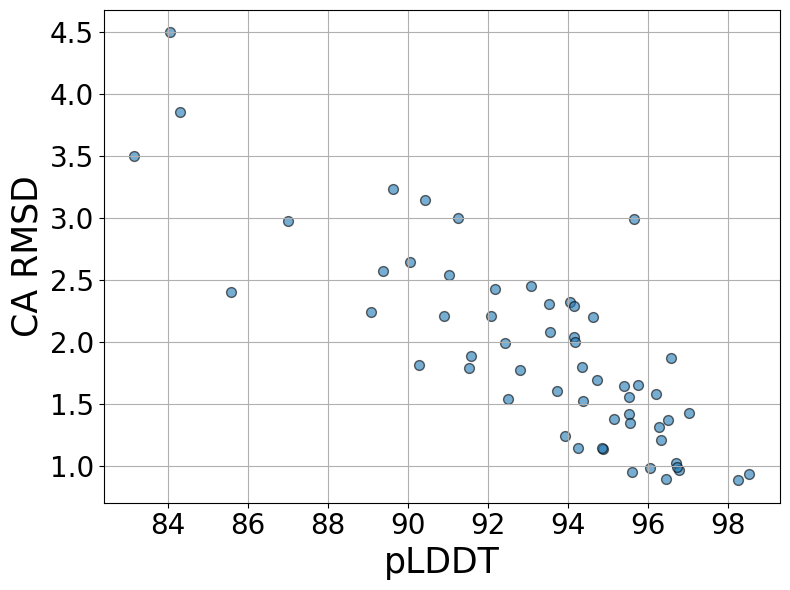

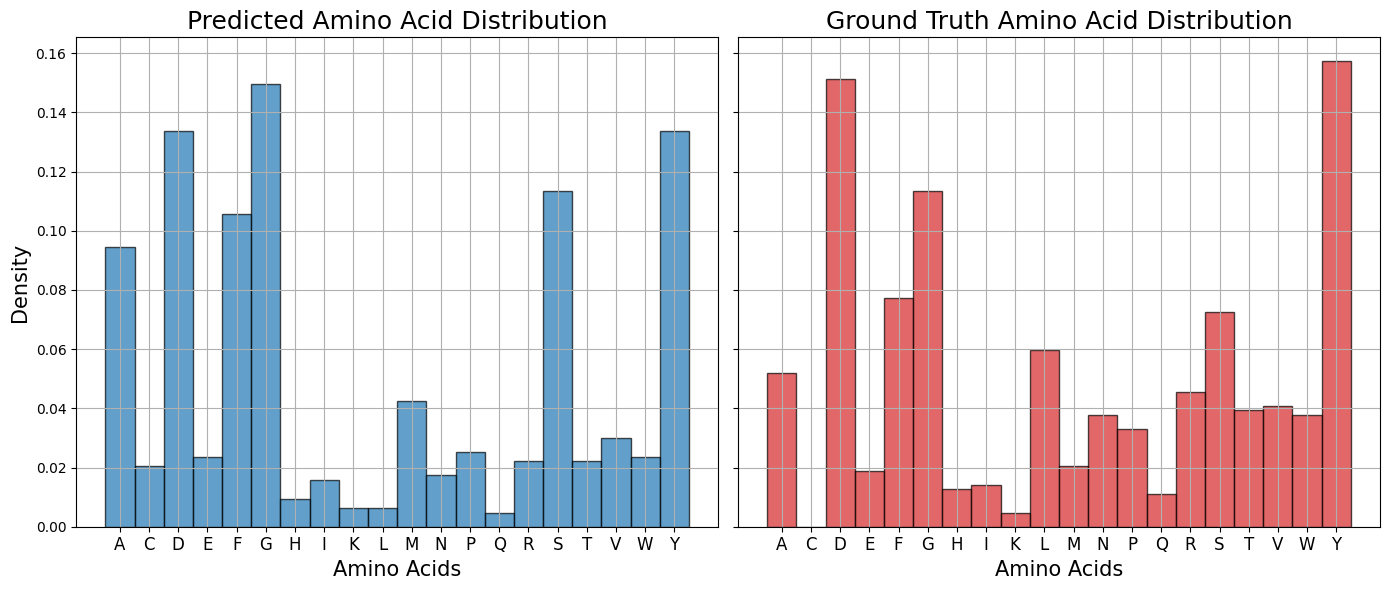

In [4]:
# plot_plddt(lddt, plddt, save_path='./figures/plddt_plot.pdf')
plot_plddt(res_plddt, res_lddt)
plot_plddt(batch_plddt, batch_lddt)
plot_scatter(batch_plddt, batch_ca_rmsd, x_label = "pLDDT", y_label="CA RMSD")
plot_aa_distribution(pred_seq, true_seq)